# SR with deep learning

### Import library

In [1]:
# import standard library
import datetime
import math

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

In [2]:
# import private module
from src import option
from src import sen12ms
from src import utils

In [3]:
# confirm setting
opt = option.Option()
print('\n'.join(opt.get_options_str()), '\n')

------------------------------------------------------------
 pjt_dir	/home/vit134/vit/sar_sr
 model_name	srgan
 scale		4
 gan_mode	gan
------------------------------------------------------------
 train_dir	/home/vit134/vit/sar_sr/data/processed/sen12ms_non_overlap_split_da/train
 val_dir	/home/vit134/vit/sar_sr/data/processed/sen12ms_non_overlap_split/validation
 test_dir	/home/vit134/vit/sar_sr/data/processed/sen12ms_non_overlap_split/test
 feature_extractor_weight_path
		/home/vit134/vit/sar_sr/data/feature_extractor/vgg19_54.pth
 log_dir	/home/vit134/vit/sar_sr/log/tmp
 model_dir	/home/vit134/vit/mnt/hdd/vit/model_tmp
 log_path_org	/home/vit134/vit/sar_sr/log/tmp/srgan_4x_.csv
 model_path_org	/home/vit134/vit/mnt/hdd/vit/model_tmp/srgan_4x_.pth
------------------------------------------------------------
 device			cuda
 parallel_processing	True
 num_workers		6
 load_highs2		False
 data_augmentation	False
 save_log		True
 save_model		True
 save_model_interval	250
 validation_interv

In [4]:
# import network module
if opt.gan_mode == 'gan':
    from model import gan
elif opt.gan_mode == 'wgan_gp':
    from model import wgan_gp
else:
    raise RuntimeError

In [5]:
# autotune cuDNN algorithm for acceleration
torch.backends.cudnn.benchmark = True

### Setup dataset

In [6]:
# create data loader
train_dataset = sen12ms.Dataset(
    data_dir=opt.train_dir,
    scale=opt.scale,
    transform=transforms.ToTensor(),
    transform_color=transforms.ToTensor(),
    mean=opt.sen12ms_mean,
    std=opt.sen12ms_std,
    load_lows2=opt.load_lows2,
    load_highs2=opt.load_highs2,
    n_im=opt.n_train_im,
    seed=opt.dataset_seed,
)
val_dataset = sen12ms.Dataset(
    data_dir=opt.val_dir,
    scale=opt.scale,
    transform=transforms.ToTensor(),
    transform_color=transforms.ToTensor(),
    mean=opt.sen12ms_mean,
    std=opt.sen12ms_std,
    load_lows2=opt.load_lows2,
    load_highs2=opt.load_highs2,
    n_im=opt.n_val_im,
    seed=opt.dataset_seed,
)

print('train : {:,} images'.format(len(train_dataset)))
print('val: {:,} images'.format(len(val_dataset)))

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=opt.batch_size, shuffle=True, num_workers=opt.num_workers, drop_last=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=opt.batch_size, shuffle=False, num_workers=opt.num_workers, drop_last=True, pin_memory=True)

train : 116,576 images
val: 2,082 images


low s1 size: torch.Size([16, 1, 64, 64])
high s1 size: torch.Size([16, 1, 256, 256])


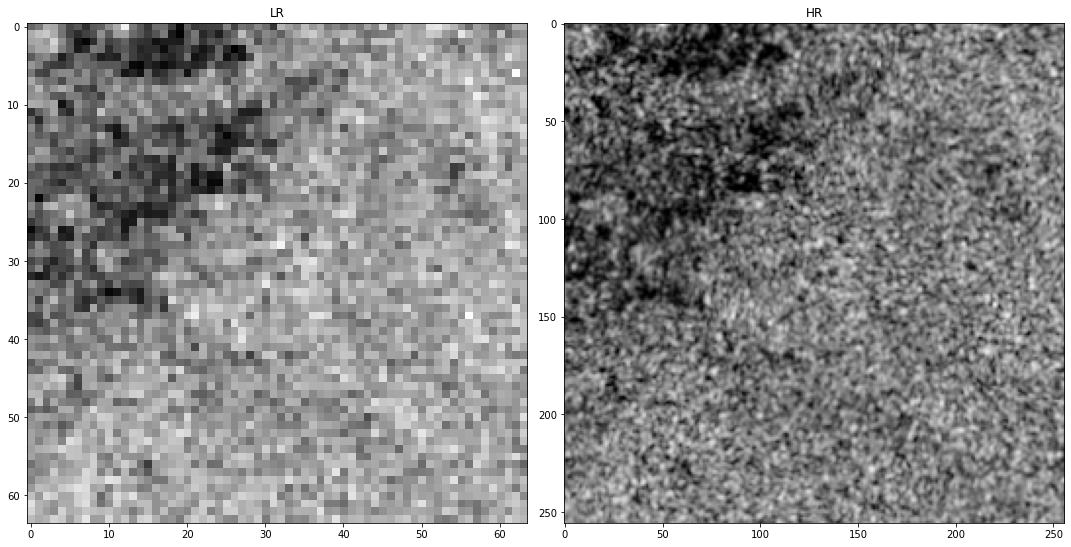

In [7]:
# check a sample image
for batch in train_loader:
    print("low s1 size: {}".format(batch.lows1.shape))
    print("high s1 size: {}".format(batch.highs1.shape))
    
    lows1 = train_dataset.un_normalize(batch.lows1)
    highs1 = train_dataset.un_normalize(batch.highs1)
    
    lows1 = utils.tensors_to_ndarray(lows1)
    highs1 = utils.tensors_to_ndarray(highs1)
    
    utils.plot_ims([lows1[0], highs1[0]], ['LR', 'HR'], row=1, col=2)
    plt.show()
    break

### Clock the start time

In [8]:
# display start time
start_time = datetime.datetime.now()
opt.update_log_model_path(start_time)
utils.show_start_time(start_time, opt.save_log, opt.save_model, opt.log_path, opt.model_path)

start: 2021/12/29 16:05:48	( 20211229-160548 )
log is saved to: /home/vit134/vit/sar_sr/log/tmp/srgan_4x_20211229-160548.csv
model is saved to: /home/vit134/vit/mnt/hdd/vit/model_tmp/srgan_4x_20211229-160548.pth


### Define the network

In [9]:
# define gan network
if opt.gan_mode == 'gan':
    gan = gan.GAN(opt=opt, cal_psnr_ssim=utils.cal_psnr_ssim, unnorm=train_dataset.norm.unnorm)
elif opt.gan_mode == 'wgan_gp':
    gan = wgan_gp.WGAN_GP(opt=opt, cal_psnr_ssim=utils.cal_psnr_ssim, cal_gradient_penalty=wgan_gp.cal_gradient_penalty)

print(gan)

GAN(
  (generator): DataParallel(
    (module): Generator(
      (conv_block1): Sequential(
        (0): Conv2d(4, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): PReLU(num_parameters=1)
      )
      (trunck): Sequential(
        (0): ResidualConvBlock(
          (rcb): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): PReLU(num_parameters=1)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): ResidualConvBlock(
          (rcb): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

### Define training function

In [10]:
# training function
def gan_train():
    step_per_epoch = math.ceil(len(train_dataset) / opt.batch_size)
    total_epoch = math.ceil(opt.total_steps / step_per_epoch)
    batches_done = 0
    
    for epoch in range(1, total_epoch + 1):
        for n_batch, batch in enumerate(train_loader):
            # display progress
            print('\r    === training now [{}/{}] ==='.format(n_batch + 1, len(train_loader)), end='')

            # ---------------
            #  training
            # ---------------
            # pre train
            if batches_done <= sum(opt.pretrain_steps):
                if batches_done <= opt.pretrain_steps[0]:
                    train_info = gan.train_g(batch)

                    if batches_done == opt.pretrain_steps[0]:
                        print('\nfinish pre-train generator', end='\n')
                else:
                    train_info = gan.train_d(batch)

                    if batches_done == sum(opt.pretrain_steps):
                        print('\nfinish pre-train discriminator', end='\n')

            # main train
            else:
                train_info = gan.train(batch)

            # save loss
            train_info.update({'n_batch': n_batch, 'epoch': epoch})
            if opt.save_log:
                gan.save_loss(info=train_info, batches_done=batches_done)

            # save model
            if opt.save_model and batches_done % opt.save_model_interval == 0:
                gan.save_weight(batches_done, opt)

            # ---------------
            #  validation
            # ---------------
            if batches_done % opt.validation_interval == 0 and batches_done != 0:
                print('\r   === validating now ===', end='                    ')
                # validate
                val_info = gan.validate(val_loader)
                if opt.save_log:
                    gan.save_loss(info=val_info, batches_done=batches_done)

                # dispaly progress
                print('\r[{}/{}] [{:,}/{:,}] val psnr: {:.4f} ssim: {:.4f}    '
                      .format(epoch, total_epoch, batches_done, opt.total_steps, val_info['val_psnr'], val_info['val_ssim']), end='\n')

            batches_done += 1

In [11]:
# training function
def wgan_gp_train():
    step_per_epoch = math.ceil(len(train_dataset) / opt.batch_size)
    total_epoch = math.ceil(opt.total_steps / step_per_epoch)
    batches_done = 0
    
    for epoch in range(1, total_epoch + 1):
        for n_batch, batch in enumerate(train_loader):
            # display progress
            print('\r    === training now [{}/{}] ==='.format(n_batch + 1, len(train_loader)), end='')

            # ---------------
            #  training
            # ---------------
            # train d
            train_info = gan.train_d(batch)

            # train g
            if batches_done % opt.train_g_interval == 0:
                info = gan.train_g(batch)
                train_info.update(info)

            # save loss
            train_info.update({'n_batch': n_batch, 'epoch': epoch})
            if opt.save_log:
                gan.save_loss(info=train_info, batches_done=batches_done)

            # save model
            if opt.save_model and batches_done % opt.save_model_interval == 0:
                gan.save_weight(batches_done, opt)

            # ---------------
            #  validation
            # ---------------
            if batches_done % opt.validation_interval == 0 and batches_done != 0:
                # validate
                val_info = gan.validate(val_loader)
                if opt.save_log:
                    gan.save_loss(info=val_info, batches_done=batches_done)

                # dispaly progress
                print('\r[{}/{}] [{:,}/{:,}] val psnr: {:.4f} ssim: {:.4f}    '
                      .format(epoch, total_epoch, batches_done, opt.total_steps, val_info['val_psnr'], val_info['val_ssim']), end='\n')

            batches_done += 1

### Train

In [12]:
# Do training
if opt.gan_mode == 'gan':
    gan_train()
elif opt.gan_mode == 'wgan_gp':
    wgan_gp_train()

[1/42] [250/300,000] val psnr: 20.1134 ssim: 0.3876    
[1/42] [500/300,000] val psnr: 21.2282 ssim: 0.4784    
[1/42] [750/300,000] val psnr: 21.6931 ssim: 0.5111    
[1/42] [1,000/300,000] val psnr: 21.9512 ssim: 0.5288    
[1/42] [1,250/300,000] val psnr: 22.1315 ssim: 0.5390    
[1/42] [1,500/300,000] val psnr: 22.2585 ssim: 0.5491    
[1/42] [1,750/300,000] val psnr: 22.3604 ssim: 0.5552    
[1/42] [2,000/300,000] val psnr: 22.4433 ssim: 0.5621    
[1/42] [2,250/300,000] val psnr: 22.4868 ssim: 0.5641    
[1/42] [2,500/300,000] val psnr: 22.5499 ssim: 0.5700    
[1/42] [2,750/300,000] val psnr: 22.5816 ssim: 0.5724    
[1/42] [3,000/300,000] val psnr: 22.6113 ssim: 0.5736    
[1/42] [3,250/300,000] val psnr: 22.6439 ssim: 0.5772    
[1/42] [3,500/300,000] val psnr: 22.6549 ssim: 0.5750    
[1/42] [3,750/300,000] val psnr: 22.6756 ssim: 0.5791    
[1/42] [4,000/300,000] val psnr: 22.6935 ssim: 0.5807    
[1/42] [4,250/300,000] val psnr: 22.7077 ssim: 0.5821    
[1/42] [4,500/300,00

[5/42] [35,000/300,000] val psnr: 22.8759 ssim: 0.5949    
[5/42] [35,250/300,000] val psnr: 22.8758 ssim: 0.5949    
[5/42] [35,500/300,000] val psnr: 22.8758 ssim: 0.5956    
[5/42] [35,750/300,000] val psnr: 22.8814 ssim: 0.5957    
[5/42] [36,000/300,000] val psnr: 22.8723 ssim: 0.5934    
[5/42] [36,250/300,000] val psnr: 22.8795 ssim: 0.5947    
[6/42] [36,500/300,000] val psnr: 22.8808 ssim: 0.5944    
[6/42] [36,750/300,000] val psnr: 22.8820 ssim: 0.5949    
[6/42] [37,000/300,000] val psnr: 22.8822 ssim: 0.5953    
[6/42] [37,250/300,000] val psnr: 22.8825 ssim: 0.5951    
[6/42] [37,500/300,000] val psnr: 22.8788 ssim: 0.5959    
[6/42] [37,750/300,000] val psnr: 22.8824 ssim: 0.5952    
[6/42] [38,000/300,000] val psnr: 22.8633 ssim: 0.5923    
[6/42] [38,250/300,000] val psnr: 22.8834 ssim: 0.5945    
[6/42] [38,500/300,000] val psnr: 22.8847 ssim: 0.5956    
[6/42] [38,750/300,000] val psnr: 22.8814 ssim: 0.5945    
[6/42] [39,000/300,000] val psnr: 22.8846 ssim: 0.5957  

[10/42] [69,500/300,000] val psnr: 22.9045 ssim: 0.5971    
[10/42] [69,750/300,000] val psnr: 22.9027 ssim: 0.5966    
[10/42] [70,000/300,000] val psnr: 22.9035 ssim: 0.5966    
[10/42] [70,250/300,000] val psnr: 22.9045 ssim: 0.5965    
[10/42] [70,500/300,000] val psnr: 22.9036 ssim: 0.5964    
[10/42] [70,750/300,000] val psnr: 22.9035 ssim: 0.5967    
[10/42] [71,000/300,000] val psnr: 22.9052 ssim: 0.5965    
[10/42] [71,250/300,000] val psnr: 22.9046 ssim: 0.5963    
[10/42] [71,500/300,000] val psnr: 22.9016 ssim: 0.5964    
[10/42] [71,750/300,000] val psnr: 22.9056 ssim: 0.5969    
[10/42] [72,000/300,000] val psnr: 22.9043 ssim: 0.5965    
[10/42] [72,250/300,000] val psnr: 22.9057 ssim: 0.5972    
[10/42] [72,500/300,000] val psnr: 22.8981 ssim: 0.5958    
[10/42] [72,750/300,000] val psnr: 22.9034 ssim: 0.5965    
[11/42] [73,000/300,000] val psnr: 22.9047 ssim: 0.5971    
[11/42] [73,250/300,000] val psnr: 22.9053 ssim: 0.5963    
[11/42] [73,500/300,000] val psnr: 22.90

[15/42] [103,500/300,000] val psnr: 22.9082 ssim: 0.5967    
[15/42] [103,750/300,000] val psnr: 22.9103 ssim: 0.5971    
[15/42] [104,000/300,000] val psnr: 22.8890 ssim: 0.5936    
[15/42] [104,250/300,000] val psnr: 22.9102 ssim: 0.5968    
[15/42] [104,500/300,000] val psnr: 22.9095 ssim: 0.5970    
[15/42] [104,750/300,000] val psnr: 22.9102 ssim: 0.5976    
[15/42] [105,000/300,000] val psnr: 22.9107 ssim: 0.5968    
[15/42] [105,250/300,000] val psnr: 22.9107 ssim: 0.5969    
[15/42] [105,500/300,000] val psnr: 22.9112 ssim: 0.5972    
[15/42] [105,750/300,000] val psnr: 22.8855 ssim: 0.5939    
[15/42] [106,000/300,000] val psnr: 22.9096 ssim: 0.5966    
[15/42] [106,250/300,000] val psnr: 22.9101 ssim: 0.5975    
[15/42] [106,500/300,000] val psnr: 22.9096 ssim: 0.5968    
[15/42] [106,750/300,000] val psnr: 22.9113 ssim: 0.5977    
[15/42] [107,000/300,000] val psnr: 22.9110 ssim: 0.5972    
[15/42] [107,250/300,000] val psnr: 22.9108 ssim: 0.5970    
[15/42] [107,500/300,000

[19/42] [137,000/300,000] val psnr: 22.9077 ssim: 0.5966    
[19/42] [137,250/300,000] val psnr: 22.9098 ssim: 0.5969    
[19/42] [137,500/300,000] val psnr: 22.9105 ssim: 0.5971    
[19/42] [137,750/300,000] val psnr: 22.9119 ssim: 0.5970    
[19/42] [138,000/300,000] val psnr: 22.9115 ssim: 0.5970    
[19/42] [138,250/300,000] val psnr: 22.9112 ssim: 0.5975    
[20/42] [138,500/300,000] val psnr: 22.9111 ssim: 0.5976    
[20/42] [138,750/300,000] val psnr: 22.9097 ssim: 0.5968    
[20/42] [139,000/300,000] val psnr: 22.9080 ssim: 0.5967    
[20/42] [139,250/300,000] val psnr: 22.9094 ssim: 0.5971    
[20/42] [139,500/300,000] val psnr: 22.9117 ssim: 0.5970    
[20/42] [139,750/300,000] val psnr: 22.9105 ssim: 0.5972    
[20/42] [140,000/300,000] val psnr: 22.9088 ssim: 0.5970    
[20/42] [140,250/300,000] val psnr: 22.9113 ssim: 0.5976    
[20/42] [140,500/300,000] val psnr: 22.9084 ssim: 0.5965    
[20/42] [140,750/300,000] val psnr: 22.9110 ssim: 0.5970    
[20/42] [141,000/300,000

[24/42] [170,500/300,000] val psnr: 22.9083 ssim: 0.5969    
[24/42] [170,750/300,000] val psnr: 22.9093 ssim: 0.5971    
[24/42] [171,000/300,000] val psnr: 22.9084 ssim: 0.5971    
[24/42] [171,250/300,000] val psnr: 22.9053 ssim: 0.5971    
[24/42] [171,500/300,000] val psnr: 22.9076 ssim: 0.5974    
[24/42] [171,750/300,000] val psnr: 22.9062 ssim: 0.5976    
[24/42] [172,000/300,000] val psnr: 22.9046 ssim: 0.5970    
[24/42] [172,250/300,000] val psnr: 22.9058 ssim: 0.5968    
[24/42] [172,500/300,000] val psnr: 22.9092 ssim: 0.5971    
[24/42] [172,750/300,000] val psnr: 22.9088 ssim: 0.5976    
[24/42] [173,000/300,000] val psnr: 22.9042 ssim: 0.5971    
[24/42] [173,250/300,000] val psnr: 22.9090 ssim: 0.5974    
[24/42] [173,500/300,000] val psnr: 22.9084 ssim: 0.5975    
[24/42] [173,750/300,000] val psnr: 22.9053 ssim: 0.5973    
[24/42] [174,000/300,000] val psnr: 22.9063 ssim: 0.5969    
[24/42] [174,250/300,000] val psnr: 22.9085 ssim: 0.5972    
[24/42] [174,500/300,000

[28/42] [204,000/300,000] val psnr: 22.9046 ssim: 0.5973    
[29/42] [204,250/300,000] val psnr: 22.8996 ssim: 0.5970    
[29/42] [204,500/300,000] val psnr: 22.9002 ssim: 0.5968    
[29/42] [204,750/300,000] val psnr: 22.9039 ssim: 0.5970    
[29/42] [205,000/300,000] val psnr: 22.9035 ssim: 0.5967    
[29/42] [205,250/300,000] val psnr: 22.9027 ssim: 0.5971    
[29/42] [205,500/300,000] val psnr: 22.9054 ssim: 0.5972    
[29/42] [205,750/300,000] val psnr: 22.9036 ssim: 0.5970    
[29/42] [206,000/300,000] val psnr: 22.9045 ssim: 0.5974    
[29/42] [206,250/300,000] val psnr: 22.9042 ssim: 0.5971    
[29/42] [206,500/300,000] val psnr: 22.9029 ssim: 0.5965    
[29/42] [206,750/300,000] val psnr: 22.9008 ssim: 0.5973    
[29/42] [207,000/300,000] val psnr: 22.9055 ssim: 0.5971    
[29/42] [207,250/300,000] val psnr: 22.9057 ssim: 0.5970    
[29/42] [207,500/300,000] val psnr: 22.9047 ssim: 0.5975    
[29/42] [207,750/300,000] val psnr: 22.9023 ssim: 0.5969    
[29/42] [208,000/300,000

[33/42] [237,500/300,000] val psnr: 22.8990 ssim: 0.5970    
[33/42] [237,750/300,000] val psnr: 22.9003 ssim: 0.5970    
[33/42] [238,000/300,000] val psnr: 22.9022 ssim: 0.5969    
[33/42] [238,250/300,000] val psnr: 22.8973 ssim: 0.5966    
[33/42] [238,500/300,000] val psnr: 22.9004 ssim: 0.5972    
[33/42] [238,750/300,000] val psnr: 22.9004 ssim: 0.5969    
[33/42] [239,000/300,000] val psnr: 22.8999 ssim: 0.5966    
[33/42] [239,250/300,000] val psnr: 22.9030 ssim: 0.5972    
[33/42] [239,500/300,000] val psnr: 22.8990 ssim: 0.5968    
[33/42] [239,750/300,000] val psnr: 22.9002 ssim: 0.5969    
[33/42] [240,000/300,000] val psnr: 22.9010 ssim: 0.5975    
[33/42] [240,250/300,000] val psnr: 22.8986 ssim: 0.5968    
[34/42] [240,500/300,000] val psnr: 22.9005 ssim: 0.5965    
[34/42] [240,750/300,000] val psnr: 22.8973 ssim: 0.5969    
[34/42] [241,000/300,000] val psnr: 22.8986 ssim: 0.5972    
[34/42] [241,250/300,000] val psnr: 22.8955 ssim: 0.5964    
[34/42] [241,500/300,000

[38/42] [271,000/300,000] val psnr: 22.8934 ssim: 0.5972    
[38/42] [271,250/300,000] val psnr: 22.8911 ssim: 0.5970    
[38/42] [271,500/300,000] val psnr: 22.8999 ssim: 0.5965    
[38/42] [271,750/300,000] val psnr: 22.8981 ssim: 0.5966    
[38/42] [272,000/300,000] val psnr: 22.8941 ssim: 0.5964    
[38/42] [272,250/300,000] val psnr: 22.8948 ssim: 0.5969    
[38/42] [272,500/300,000] val psnr: 22.8961 ssim: 0.5965    
[38/42] [272,750/300,000] val psnr: 22.8960 ssim: 0.5964    
[38/42] [273,000/300,000] val psnr: 22.8939 ssim: 0.5956    
[38/42] [273,250/300,000] val psnr: 22.8973 ssim: 0.5964    
[38/42] [273,500/300,000] val psnr: 22.8937 ssim: 0.5962    
[38/42] [273,750/300,000] val psnr: 22.8993 ssim: 0.5972    
[38/42] [274,000/300,000] val psnr: 22.8946 ssim: 0.5963    
[38/42] [274,250/300,000] val psnr: 22.8955 ssim: 0.5970    
[38/42] [274,500/300,000] val psnr: 22.8957 ssim: 0.5968    
[38/42] [274,750/300,000] val psnr: 22.8927 ssim: 0.5970    
[38/42] [275,000/300,000

[42/42] [304,500/300,000] val psnr: 22.9001 ssim: 0.5975    
[42/42] [304,750/300,000] val psnr: 22.8967 ssim: 0.5960    
[42/42] [305,000/300,000] val psnr: 22.9004 ssim: 0.5967    
[42/42] [305,250/300,000] val psnr: 22.8978 ssim: 0.5970    
[42/42] [305,500/300,000] val psnr: 22.8922 ssim: 0.5966    
[42/42] [305,750/300,000] val psnr: 22.8903 ssim: 0.5967    
[42/42] [306,000/300,000] val psnr: 22.8947 ssim: 0.5967    
    === training now [7286/7286] ===

### Clock the end time

In [13]:
# display end time
end_time = datetime.datetime.now()
utils.show_end_time(start_time, end_time)

end: 2022/01/02 04:35:58
Took : 3d, 12:30:9.76
